In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import cv2
from torch.utils.data import DataLoader
from scipy.ndimage import zoom
from tqdm import tqdm


# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load datasets
train_dataset = datasets.ImageFolder(root="/content/drive/MyDrive/data/data/train", transform=transform)
val_dataset = datasets.ImageFolder(root="/content/drive/MyDrive/data/data/val", transform=transform)
test_dataset = datasets.ImageFolder(root="/content/drive/MyDrive/data/data/test", transform=transform)

# Data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define CNN model
class CNN(nn.Module):
    def __init__(self, num_classes=21):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        feature_maps = x  # Store feature maps for CAM
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x, feature_maps

# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
model = CNN(num_classes=21).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train and evaluate the model
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=100):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs, _ = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = correct / total

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct, val_total = 0, 0

        with torch.no_grad():
            for val_images, val_labels in tqdm(val_loader):
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                val_outputs, _ = model(val_images)
                val_loss += criterion(val_outputs, val_labels).item()
                _, val_predicted = torch.max(val_outputs, 1)
                val_total += val_labels.size(0)
                val_correct += (val_predicted == val_labels).sum().item()

        val_acc = val_correct / val_total

        print(f"Epoch {epoch+1}, Train Loss: {running_loss/len(train_loader):.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.4f}")

    # Save the trained model
    torch.save(model.state_dict(), f"cnn_model_{epoch+1}.pth")
    print("Model saved successfully!")

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=100)


Device: cuda


100%|██████████| 13/13 [03:07<00:00, 14.45s/it]


Epoch 1, Train Loss: 3.0193, Train Acc: 0.0823, Val Loss: 2.9512, Val Acc: 0.1724


100%|██████████| 13/13 [00:02<00:00,  6.16it/s]


Epoch 2, Train Loss: 2.9421, Train Acc: 0.1824, Val Loss: 2.8838, Val Acc: 0.2365


100%|██████████| 13/13 [00:01<00:00,  6.75it/s]


Epoch 3, Train Loss: 2.9090, Train Acc: 0.2100, Val Loss: 2.8998, Val Acc: 0.2217


100%|██████████| 13/13 [00:01<00:00,  7.24it/s]


Epoch 4, Train Loss: 2.8989, Train Acc: 0.2181, Val Loss: 2.8700, Val Acc: 0.2463


100%|██████████| 13/13 [00:01<00:00,  7.26it/s]


Epoch 5, Train Loss: 2.8843, Train Acc: 0.2327, Val Loss: 2.8146, Val Acc: 0.3054


100%|██████████| 13/13 [00:01<00:00,  7.37it/s]


Epoch 6, Train Loss: 2.8292, Train Acc: 0.2960, Val Loss: 2.8215, Val Acc: 0.3030


100%|██████████| 13/13 [00:01<00:00,  7.24it/s]


Epoch 7, Train Loss: 2.8327, Train Acc: 0.2906, Val Loss: 2.8129, Val Acc: 0.3054


100%|██████████| 13/13 [00:01<00:00,  7.32it/s]


Epoch 8, Train Loss: 2.8228, Train Acc: 0.3003, Val Loss: 2.8103, Val Acc: 0.3054


100%|██████████| 13/13 [00:01<00:00,  7.33it/s]


Epoch 9, Train Loss: 2.8192, Train Acc: 0.3036, Val Loss: 2.7765, Val Acc: 0.3374


100%|██████████| 13/13 [00:02<00:00,  6.45it/s]


Epoch 10, Train Loss: 2.8193, Train Acc: 0.3014, Val Loss: 2.7751, Val Acc: 0.3399


100%|██████████| 13/13 [00:02<00:00,  6.09it/s]


Epoch 11, Train Loss: 2.8181, Train Acc: 0.3030, Val Loss: 2.7834, Val Acc: 0.3399


100%|██████████| 13/13 [00:01<00:00,  6.86it/s]


Epoch 12, Train Loss: 2.8085, Train Acc: 0.3144, Val Loss: 2.7938, Val Acc: 0.3300


100%|██████████| 13/13 [00:01<00:00,  7.36it/s]


Epoch 13, Train Loss: 2.7751, Train Acc: 0.3458, Val Loss: 2.7639, Val Acc: 0.3571


100%|██████████| 13/13 [00:01<00:00,  7.30it/s]


Epoch 14, Train Loss: 2.7972, Train Acc: 0.3247, Val Loss: 2.8667, Val Acc: 0.2537


100%|██████████| 13/13 [00:01<00:00,  7.27it/s]


Epoch 15, Train Loss: 2.8332, Train Acc: 0.2890, Val Loss: 2.8539, Val Acc: 0.2586


100%|██████████| 13/13 [00:01<00:00,  7.29it/s]


Epoch 16, Train Loss: 2.8140, Train Acc: 0.3095, Val Loss: 2.7380, Val Acc: 0.3793


100%|██████████| 13/13 [00:01<00:00,  7.26it/s]


Epoch 17, Train Loss: 2.7743, Train Acc: 0.3490, Val Loss: 2.7647, Val Acc: 0.3596


100%|██████████| 13/13 [00:01<00:00,  7.36it/s]


Epoch 18, Train Loss: 2.7597, Train Acc: 0.3636, Val Loss: 2.7311, Val Acc: 0.3818


100%|██████████| 13/13 [00:01<00:00,  6.54it/s]


Epoch 19, Train Loss: 2.7458, Train Acc: 0.3777, Val Loss: 2.7387, Val Acc: 0.3867


100%|██████████| 13/13 [00:02<00:00,  6.20it/s]


Epoch 20, Train Loss: 2.7617, Train Acc: 0.3609, Val Loss: 2.6901, Val Acc: 0.4187


100%|██████████| 13/13 [00:01<00:00,  7.02it/s]


Epoch 21, Train Loss: 2.7599, Train Acc: 0.3626, Val Loss: 2.7019, Val Acc: 0.4138


100%|██████████| 13/13 [00:01<00:00,  7.27it/s]


Epoch 22, Train Loss: 2.7438, Train Acc: 0.3810, Val Loss: 2.7186, Val Acc: 0.3990


100%|██████████| 13/13 [00:01<00:00,  7.25it/s]


Epoch 23, Train Loss: 2.7765, Train Acc: 0.3469, Val Loss: 2.7075, Val Acc: 0.4138


100%|██████████| 13/13 [00:01<00:00,  7.17it/s]


Epoch 24, Train Loss: 2.7476, Train Acc: 0.3739, Val Loss: 2.7094, Val Acc: 0.4163


100%|██████████| 13/13 [00:01<00:00,  7.26it/s]


Epoch 25, Train Loss: 2.7464, Train Acc: 0.3750, Val Loss: 2.7040, Val Acc: 0.4113


100%|██████████| 13/13 [00:01<00:00,  7.38it/s]


Epoch 26, Train Loss: 2.7412, Train Acc: 0.3826, Val Loss: 2.6884, Val Acc: 0.4335


100%|██████████| 13/13 [00:01<00:00,  7.13it/s]


Epoch 27, Train Loss: 2.7297, Train Acc: 0.3945, Val Loss: 2.6709, Val Acc: 0.4409


100%|██████████| 13/13 [00:02<00:00,  6.39it/s]


Epoch 28, Train Loss: 2.7333, Train Acc: 0.3912, Val Loss: 2.6586, Val Acc: 0.4606


100%|██████████| 13/13 [00:02<00:00,  6.18it/s]


Epoch 29, Train Loss: 2.7262, Train Acc: 0.3961, Val Loss: 2.6977, Val Acc: 0.4236


100%|██████████| 13/13 [00:01<00:00,  6.93it/s]


Epoch 30, Train Loss: 2.7456, Train Acc: 0.3777, Val Loss: 2.7046, Val Acc: 0.4163


100%|██████████| 13/13 [00:01<00:00,  7.45it/s]


Epoch 31, Train Loss: 2.7316, Train Acc: 0.3912, Val Loss: 2.6703, Val Acc: 0.4483


100%|██████████| 13/13 [00:01<00:00,  7.41it/s]


Epoch 32, Train Loss: 2.7276, Train Acc: 0.3966, Val Loss: 2.6807, Val Acc: 0.4409


100%|██████████| 13/13 [00:01<00:00,  7.33it/s]


Epoch 33, Train Loss: 2.7131, Train Acc: 0.4091, Val Loss: 2.7252, Val Acc: 0.3916


100%|██████████| 13/13 [00:01<00:00,  7.37it/s]


Epoch 34, Train Loss: 2.7412, Train Acc: 0.3815, Val Loss: 2.6510, Val Acc: 0.4704


100%|██████████| 13/13 [00:01<00:00,  7.22it/s]


Epoch 35, Train Loss: 2.7237, Train Acc: 0.3983, Val Loss: 2.6602, Val Acc: 0.4631


100%|██████████| 13/13 [00:01<00:00,  7.18it/s]


Epoch 36, Train Loss: 2.6991, Train Acc: 0.4226, Val Loss: 2.6624, Val Acc: 0.4631


100%|██████████| 13/13 [00:02<00:00,  6.23it/s]


Epoch 37, Train Loss: 2.7270, Train Acc: 0.3956, Val Loss: 2.6572, Val Acc: 0.4631


100%|██████████| 13/13 [00:02<00:00,  6.33it/s]


Epoch 38, Train Loss: 2.6920, Train Acc: 0.4307, Val Loss: 2.6381, Val Acc: 0.4803


100%|██████████| 13/13 [00:01<00:00,  7.27it/s]


Epoch 39, Train Loss: 2.7166, Train Acc: 0.4075, Val Loss: 2.6776, Val Acc: 0.4433


100%|██████████| 13/13 [00:01<00:00,  7.31it/s]


Epoch 40, Train Loss: 2.6986, Train Acc: 0.4248, Val Loss: 2.6318, Val Acc: 0.4828


100%|██████████| 13/13 [00:01<00:00,  7.39it/s]


Epoch 41, Train Loss: 2.6813, Train Acc: 0.4416, Val Loss: 2.6432, Val Acc: 0.4704


100%|██████████| 13/13 [00:01<00:00,  7.35it/s]


Epoch 42, Train Loss: 2.6783, Train Acc: 0.4443, Val Loss: 2.6449, Val Acc: 0.4680


100%|██████████| 13/13 [00:01<00:00,  7.43it/s]


Epoch 43, Train Loss: 2.6849, Train Acc: 0.4394, Val Loss: 2.6208, Val Acc: 0.4951


100%|██████████| 13/13 [00:01<00:00,  7.38it/s]


Epoch 44, Train Loss: 2.6836, Train Acc: 0.4383, Val Loss: 2.6309, Val Acc: 0.4852


100%|██████████| 13/13 [00:01<00:00,  6.91it/s]


Epoch 45, Train Loss: 2.6804, Train Acc: 0.4437, Val Loss: 2.6504, Val Acc: 0.4655


100%|██████████| 13/13 [00:02<00:00,  6.12it/s]


Epoch 46, Train Loss: 2.6735, Train Acc: 0.4486, Val Loss: 2.6467, Val Acc: 0.4704


100%|██████████| 13/13 [00:01<00:00,  6.65it/s]


Epoch 47, Train Loss: 2.6695, Train Acc: 0.4535, Val Loss: 2.6714, Val Acc: 0.4458


100%|██████████| 13/13 [00:01<00:00,  7.16it/s]


Epoch 48, Train Loss: 2.6703, Train Acc: 0.4518, Val Loss: 2.6507, Val Acc: 0.4680


100%|██████████| 13/13 [00:01<00:00,  7.34it/s]


Epoch 49, Train Loss: 2.6775, Train Acc: 0.4470, Val Loss: 2.6614, Val Acc: 0.4532


100%|██████████| 13/13 [00:01<00:00,  7.30it/s]


Epoch 50, Train Loss: 2.6832, Train Acc: 0.4394, Val Loss: 2.6200, Val Acc: 0.4951


100%|██████████| 13/13 [00:01<00:00,  7.11it/s]


Epoch 51, Train Loss: 2.6629, Train Acc: 0.4605, Val Loss: 2.6077, Val Acc: 0.5074


100%|██████████| 13/13 [00:01<00:00,  7.40it/s]


Epoch 52, Train Loss: 2.6559, Train Acc: 0.4670, Val Loss: 2.6547, Val Acc: 0.4606


100%|██████████| 13/13 [00:01<00:00,  7.32it/s]


Epoch 53, Train Loss: 2.6775, Train Acc: 0.4443, Val Loss: 2.6196, Val Acc: 0.4975


100%|██████████| 13/13 [00:01<00:00,  6.68it/s]


Epoch 54, Train Loss: 2.6791, Train Acc: 0.4443, Val Loss: 2.6171, Val Acc: 0.4951


100%|██████████| 13/13 [00:02<00:00,  6.10it/s]


Epoch 55, Train Loss: 2.6836, Train Acc: 0.4394, Val Loss: 2.6830, Val Acc: 0.4310


100%|██████████| 13/13 [00:01<00:00,  6.85it/s]


Epoch 56, Train Loss: 2.6585, Train Acc: 0.4637, Val Loss: 2.6096, Val Acc: 0.5025


100%|██████████| 13/13 [00:01<00:00,  7.40it/s]


Epoch 57, Train Loss: 2.6492, Train Acc: 0.4746, Val Loss: 2.6218, Val Acc: 0.4926


100%|██████████| 13/13 [00:01<00:00,  7.31it/s]


Epoch 58, Train Loss: 2.6493, Train Acc: 0.4740, Val Loss: 2.6031, Val Acc: 0.5099


100%|██████████| 13/13 [00:01<00:00,  7.37it/s]


Epoch 59, Train Loss: 2.6311, Train Acc: 0.4903, Val Loss: 2.6014, Val Acc: 0.5123


100%|██████████| 13/13 [00:01<00:00,  7.39it/s]


Epoch 60, Train Loss: 2.6359, Train Acc: 0.4876, Val Loss: 2.6466, Val Acc: 0.4680


100%|██████████| 13/13 [00:01<00:00,  7.22it/s]


Epoch 61, Train Loss: 2.6181, Train Acc: 0.5054, Val Loss: 2.5698, Val Acc: 0.5468


100%|██████████| 13/13 [00:01<00:00,  7.06it/s]


Epoch 62, Train Loss: 2.6165, Train Acc: 0.5060, Val Loss: 2.5897, Val Acc: 0.5246


100%|██████████| 13/13 [00:01<00:00,  6.58it/s]


Epoch 63, Train Loss: 2.6153, Train Acc: 0.5070, Val Loss: 2.5587, Val Acc: 0.5567


100%|██████████| 13/13 [00:02<00:00,  6.05it/s]


Epoch 64, Train Loss: 2.6500, Train Acc: 0.4740, Val Loss: 2.7304, Val Acc: 0.3941


100%|██████████| 13/13 [00:02<00:00,  6.31it/s]


Epoch 65, Train Loss: 2.6489, Train Acc: 0.4746, Val Loss: 2.5722, Val Acc: 0.5419


100%|██████████| 13/13 [00:01<00:00,  7.13it/s]


Epoch 66, Train Loss: 2.6141, Train Acc: 0.5097, Val Loss: 2.5529, Val Acc: 0.5616


100%|██████████| 13/13 [00:01<00:00,  7.20it/s]


Epoch 67, Train Loss: 2.6002, Train Acc: 0.5227, Val Loss: 2.5499, Val Acc: 0.5640


100%|██████████| 13/13 [00:01<00:00,  7.19it/s]


Epoch 68, Train Loss: 2.6048, Train Acc: 0.5179, Val Loss: 2.5802, Val Acc: 0.5345


100%|██████████| 13/13 [00:01<00:00,  7.18it/s]


Epoch 69, Train Loss: 2.6139, Train Acc: 0.5087, Val Loss: 2.5486, Val Acc: 0.5640


100%|██████████| 13/13 [00:01<00:00,  7.15it/s]


Epoch 70, Train Loss: 2.5852, Train Acc: 0.5384, Val Loss: 2.5689, Val Acc: 0.5443


100%|██████████| 13/13 [00:01<00:00,  7.06it/s]


Epoch 71, Train Loss: 2.5958, Train Acc: 0.5276, Val Loss: 2.5665, Val Acc: 0.5493


100%|██████████| 13/13 [00:01<00:00,  7.24it/s]


Epoch 72, Train Loss: 2.6001, Train Acc: 0.5222, Val Loss: 2.5550, Val Acc: 0.5616


100%|██████████| 13/13 [00:01<00:00,  6.70it/s]


Epoch 73, Train Loss: 2.5820, Train Acc: 0.5406, Val Loss: 2.5505, Val Acc: 0.5665


100%|██████████| 13/13 [00:02<00:00,  5.49it/s]


Epoch 74, Train Loss: 2.6022, Train Acc: 0.5222, Val Loss: 2.5643, Val Acc: 0.5517


100%|██████████| 13/13 [00:02<00:00,  6.36it/s]


Epoch 75, Train Loss: 2.5804, Train Acc: 0.5422, Val Loss: 2.5558, Val Acc: 0.5591


100%|██████████| 13/13 [00:01<00:00,  7.08it/s]


Epoch 76, Train Loss: 2.6246, Train Acc: 0.4978, Val Loss: 2.5484, Val Acc: 0.5640


100%|██████████| 13/13 [00:01<00:00,  6.93it/s]


Epoch 77, Train Loss: 2.5703, Train Acc: 0.5530, Val Loss: 2.5396, Val Acc: 0.5764


100%|██████████| 13/13 [00:01<00:00,  6.97it/s]


Epoch 78, Train Loss: 2.5672, Train Acc: 0.5552, Val Loss: 2.5383, Val Acc: 0.5788


100%|██████████| 13/13 [00:01<00:00,  7.04it/s]


Epoch 79, Train Loss: 2.5821, Train Acc: 0.5406, Val Loss: 2.5276, Val Acc: 0.5887


100%|██████████| 13/13 [00:01<00:00,  7.10it/s]


Epoch 80, Train Loss: 2.5778, Train Acc: 0.5449, Val Loss: 2.5355, Val Acc: 0.5788


100%|██████████| 13/13 [00:01<00:00,  7.08it/s]


Epoch 81, Train Loss: 2.5935, Train Acc: 0.5292, Val Loss: 2.5360, Val Acc: 0.5813


100%|██████████| 13/13 [00:01<00:00,  7.07it/s]


Epoch 82, Train Loss: 2.5653, Train Acc: 0.5590, Val Loss: 2.5416, Val Acc: 0.5739


100%|██████████| 13/13 [00:01<00:00,  7.28it/s]


Epoch 83, Train Loss: 2.5656, Train Acc: 0.5563, Val Loss: 2.5302, Val Acc: 0.5837


100%|██████████| 13/13 [00:01<00:00,  6.57it/s]


Epoch 84, Train Loss: 2.5506, Train Acc: 0.5720, Val Loss: 2.5172, Val Acc: 0.5985


100%|██████████| 13/13 [00:02<00:00,  6.14it/s]


Epoch 85, Train Loss: 2.5479, Train Acc: 0.5758, Val Loss: 2.5060, Val Acc: 0.6108


100%|██████████| 13/13 [00:02<00:00,  6.27it/s]


Epoch 86, Train Loss: 2.5450, Train Acc: 0.5785, Val Loss: 2.5060, Val Acc: 0.6108


100%|██████████| 13/13 [00:01<00:00,  7.20it/s]


Epoch 87, Train Loss: 2.5366, Train Acc: 0.5860, Val Loss: 2.5212, Val Acc: 0.5936


100%|██████████| 13/13 [00:01<00:00,  7.14it/s]


Epoch 88, Train Loss: 2.5396, Train Acc: 0.5828, Val Loss: 2.5142, Val Acc: 0.6010


100%|██████████| 13/13 [00:01<00:00,  7.05it/s]


Epoch 89, Train Loss: 2.5404, Train Acc: 0.5833, Val Loss: 2.5220, Val Acc: 0.5936


100%|██████████| 13/13 [00:01<00:00,  7.08it/s]


Epoch 90, Train Loss: 2.5679, Train Acc: 0.5541, Val Loss: 2.5384, Val Acc: 0.5764


100%|██████████| 13/13 [00:01<00:00,  7.13it/s]


Epoch 91, Train Loss: 2.5725, Train Acc: 0.5498, Val Loss: 2.5142, Val Acc: 0.6010


100%|██████████| 13/13 [00:01<00:00,  7.20it/s]


Epoch 92, Train Loss: 2.5484, Train Acc: 0.5752, Val Loss: 2.5176, Val Acc: 0.5985


100%|██████████| 13/13 [00:01<00:00,  7.23it/s]


Epoch 93, Train Loss: 2.5485, Train Acc: 0.5752, Val Loss: 2.5012, Val Acc: 0.6133


100%|██████████| 13/13 [00:01<00:00,  7.12it/s]


Epoch 94, Train Loss: 2.5476, Train Acc: 0.5752, Val Loss: 2.5071, Val Acc: 0.6084


100%|██████████| 13/13 [00:02<00:00,  6.12it/s]


Epoch 95, Train Loss: 2.5374, Train Acc: 0.5850, Val Loss: 2.4876, Val Acc: 0.6305


100%|██████████| 13/13 [00:02<00:00,  6.18it/s]


Epoch 96, Train Loss: 2.5351, Train Acc: 0.5871, Val Loss: 2.4947, Val Acc: 0.6207


100%|██████████| 13/13 [00:01<00:00,  7.07it/s]


Epoch 97, Train Loss: 2.5401, Train Acc: 0.5828, Val Loss: 2.4870, Val Acc: 0.6305


100%|██████████| 13/13 [00:01<00:00,  7.13it/s]


Epoch 98, Train Loss: 2.5232, Train Acc: 0.5990, Val Loss: 2.4837, Val Acc: 0.6330


100%|██████████| 13/13 [00:01<00:00,  7.20it/s]


Epoch 99, Train Loss: 2.5317, Train Acc: 0.5925, Val Loss: 2.5042, Val Acc: 0.6133


100%|██████████| 13/13 [00:01<00:00,  7.28it/s]


Epoch 100, Train Loss: 2.5266, Train Acc: 0.5963, Val Loss: 2.4871, Val Acc: 0.6305
Model saved successfully!


In [15]:
# Evaluation function
def evaluate_model(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in tqdm(loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs[0], 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

test_acc = evaluate_model(model, test_loader)
print(f"Test Accuracy: {test_acc:.4f}")

100%|██████████| 24/24 [00:03<00:00,  7.34it/s]

Test Accuracy: 0.6159


In [16]:
# CAM visualization function
def generate_cam(model, image, H=128, W=128):
    model.eval()
    image = image.to(device).unsqueeze(0)
    output, feature_maps = model(image)
    predicted_class = torch.argmax(output, dim=1).item()

    # Get the weights of the last fully connected layer
    fc_weights = model.fc2.weight[predicted_class].cpu().detach().numpy()
    feature_maps = feature_maps.squeeze(0).cpu().detach().numpy()

    num_channels = min(len(fc_weights), feature_maps.shape[0])  # Ensure alignment
    cam = np.zeros(feature_maps.shape[1:])
    for i in range(num_channels):
      cam += fc_weights[i] * feature_maps[i, :, :]

    cam = zoom(cam, (H / cam.shape[0], W / cam.shape[1]))
    cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))

    return cam

# Function to overlay CAM on image
def visualize_cam(model, image):
    cam = generate_cam(model, image)
    image_np = image.permute(1, 2, 0).cpu().numpy()
    image_np = (image_np * 0.5) + 0.5  # Denormalize

    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    superimposed_img = (heatmap * 0.4 + image_np * 255).astype(np.uint8)

    plt.figure(figsize=(6, 6))
    plt.imshow(superimposed_img)
    plt.axis("off")
    plt.show()

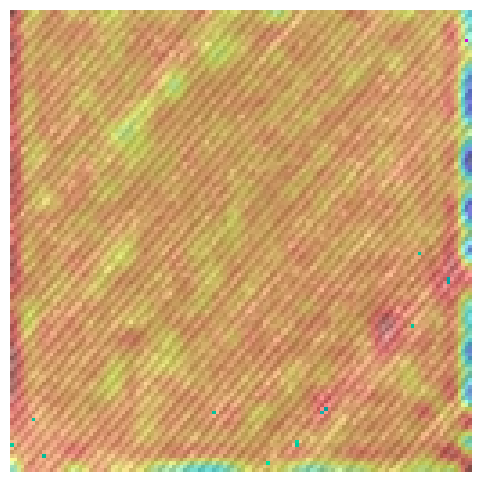

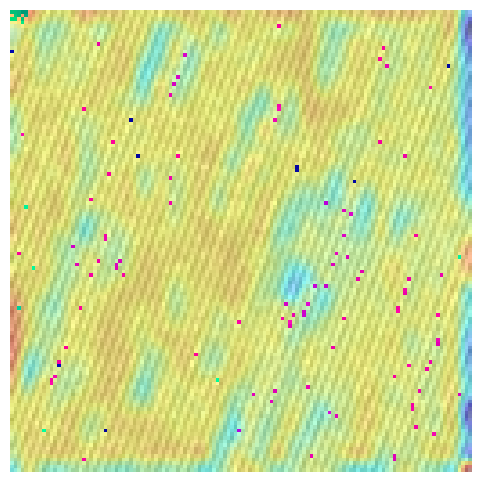

In [17]:
# Visualize CAM for sample images
sample_images, _ = next(iter(test_loader))
for i in range(2):
    visualize_cam(model, sample_images[i])